In [3]:
# PYTHON IMPORTS
import numpy as np #basic python library
import matplotlib.pyplot as plt #For plotting results
from matplotlib.pyplot import figure, legend, plot, show, title, xlabel, ylabel, ylim
import cv2 
from random import randint
import math

# LANDLAB COMPONENTS 
from landlab.components import DepressionFinderAndRouter #Pit filling
from landlab.components import PriorityFloodFlowRouter #Flow routing
from landlab.components import FlowAccumulator #FlowAccumulator 
from landlab.components import ChannelProfiler 
from landlab.components import SteepnessFinder
from landlab.components import ChiFinder
from landlab.components import ExponentialWeatherer
from landlab.components import DepthDependentDiffuser
from landlab.components import SpatialPrecipitationDistribution
from landlab.components import OverlandFlow
from landlab.components import PrecipitationDistribution

# SPACE COMPONENTS 
from landlab.components import Space #SPACE model
from landlab.components import SpaceLargeScaleEroder #basically SPACE 2.0 -- use this 
from landlab.components import FastscapeEroder #calculates the amount of erosion at each node
from landlab.components import SinkFillerBarnes #replaces pits with shallow gradients for draining

# LANDLAB UTILITIES 
from landlab import RasterModelGrid #Grid utility
from landlab import imshow_grid #For plotting results
from landlab.io import read_esri_ascii #to read in an ascii file
from landlab.io import read_asc_header #to read in the header of the ascii file
from landlab.io import write_esri_ascii 
from landlab.utils.flow__distance import calculate_flow__distance

%matplotlib inline

retrieving the topography from ascii

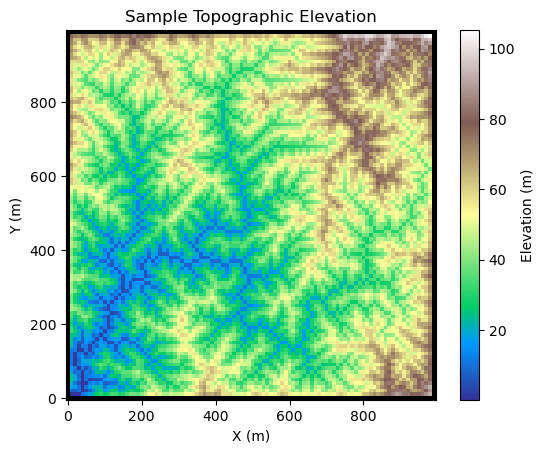

In [4]:
# GRID SPECS
ncols = 100
nrows = 100
cellsize = 10

# RETRIEVE TOPO FROM ASCII
topo_dem = "sample_topo2_topographic__elevation.txt" #the name of the ascii file
topo_path = topo_dem
topo_header = read_asc_header(open(topo_path, 'r'))
(mg, z) = read_esri_ascii(topo_path, name = 'topographic__elevation', halo = 0) #generating the new grid

# FIND OUTLET
open_nodes = mg.core_nodes
min_topo = mg['node']['topographic__elevation'].argmin()
min_topo_ID = open_nodes[min_topo]
outlet_id = mg.set_watershed_boundary_condition_outlet_id(min_topo_ID, mg['node']['topographic__elevation'], -9999)
outlet_id = min_topo_ID

# HYDROLOGICALLY FILL THE aDEM
sfb = SinkFillerBarnes(mg, surface=z, method='D8', fill_flat=False) #creating an instance of sinkfillerbarnes 
sfb.run_one_step() #This is important to ensure that your future flow routing will work properly. - run the sinkfiller barnes once

# CLOSE BOUNDARIES
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,left_is_closed=True,right_is_closed=True,top_is_closed=True)

# PLOT THE TOPOGRAPHY 
figelev = plt.figure()#Instantiate figure as empty plot
plot = plt.subplot()#Instantiate subplot as empty plot
imshow_grid(mg, 'topographic__elevation', plot_name='Sample Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)
fname = "final_plots/sample_INITIAL_TOPO.png"
figelev.savefig(fname, dpi='figure', format=None)

In [5]:
# PARAMETERS FOR SPACE
K_sed = 0.0001
K_sp = 0.001
K_br = 0.0001
F_f = 0.0
phi = 0.0
H_star = 1.0
v_s = 5.0
m_sp = 0.5
n_sp = 1.0
sp_crit_sed = 0
sp_crit_br = 0


# SET MODEL TIME PARAM
sp_timestep = 1/8760
#run_time = 100 #years
uplift_rate = .001 # m/year
uplift_per_timestep = uplift_rate * sp_timestep
soil_per_per_timestep = 0.00000014155 #m/year

# ADDING SOIL FIELD
mg.add_zeros('node', 'soil__depth')
mg.at_node['soil__depth'][:] = 2  #Set 2 m of initial soil depth at core nodes

# ADDING BEDROCK FIELD
mg.add_zeros('bedrock__elevation', at='node')
mg.at_node["bedrock__elevation"][:] = mg.at_node["topographic__elevation"] - mg.at_node['soil__depth']

# SETTING UP OUTLET ID 
mg.at_node['bedrock__elevation'][outlet_id] = 0
mg.at_node['topographic__elevation'][outlet_id] = 0
mg.at_node['soil__depth'][outlet_id] = 0
print(outlet_id)

# ADDING SURFACE WATER DEPTH
mg.add_zeros('surface_water__depth', at='node')

# ADDING SURFACE WATER DISCHARGE
mg["node"]["surface_water__discharge"] = np.zeros(mg.number_of_nodes)

#INSTANTIATING COMPONENTS 
fr = PriorityFloodFlowRouter(mg, flow_metric='D8', suppress_out = True)

fa = FlowAccumulator(mg, flow_director='D8') 

df = DepressionFinderAndRouter(mg,pits = 'flow__sink_flag', reroute_flow = True) 

fsc = FastscapeEroder(mg, K_sp, m_sp, n_sp)

sp = SpaceLargeScaleEroder(mg, K_sed, K_br, F_f, phi, H_star, v_s, m_sp, n_sp, sp_crit_sed, sp_crit_br, discharge_field='water__unit_flux_in')# K_sed, K_br, F_f, phi, H_star, v_s, m_sp, n_sp, sp_crit_sed, sp_crit_br 

soilrate = mg.add_ones("soil_production__rate", at="node")

expweath = ExponentialWeatherer(mg)

DDdiff = DepthDependentDiffuser(mg, .0001)

print('soil')
print(expweath.calc_soil_prod_rate())

print(np.allclose(mg.at_node['soil_production__rate'], .0001))

# RUNNING FSC FOR 1 YEAR TO IDENTIFY CHANNELS 
fa.run_one_step()
df.map_depressions()
fsc.run_one_step(1)

# SET UP CHANNEL PROFILER AND RUN 
profiler = ChannelProfiler(mg,number_of_watersheds=1,minimum_channel_threshold=0,main_channel_only=True)
profiler.run_one_step()
profiler.data_structure.keys() #is [101]
profiler.data_structure[101].keys()
profiler.data_structure[101][(101,9687)]["ids"] #produces array of id values for the channel

101
soil
None
False


array([ 101,  102,  103,  204,  304,  404,  504,  604,  704,  803,  902,
       1002, 1102, 1202, 1303, 1304, 1205, 1306, 1406, 1507, 1608, 1709,
       1810, 1911, 2011, 2111, 2211, 2312, 2411, 2511, 2612, 2713, 2814,
       2915, 2916, 3017, 3117, 3218, 3219, 3220, 3321, 3421, 3520, 3620,
       3721, 3822, 3723, 3824, 3925, 3926, 3927, 3828, 3829, 3830, 3731,
       3632, 3633, 3734, 3735, 3836, 3837, 3838, 3739, 3740, 3741, 3642,
       3643, 3744, 3745, 3746, 3647, 3548, 3448, 3349, 3249, 3149, 3048,
       2947, 2846, 2747, 2648, 2549, 2448, 2447, 2346, 2247, 2147, 2048,
       1949, 1950, 1951, 2052, 1953, 1954, 1855, 1756, 1657, 1558, 1559,
       1460, 1361, 1462, 1563, 1664, 1764, 1864, 1965, 2065, 2165, 2266,
       2366, 2465, 2565, 2665, 2766, 2767, 2768, 2669, 2770, 2871, 2972,
       2973, 3074, 3175, 3076, 3077, 3178, 3279, 3180, 3281, 3382, 3481,
       3581, 3681, 3781, 3880, 3981, 4081, 4180, 4281, 4381, 4482, 4583,
       4584, 4585, 4686, 4687, 4588, 4589, 4690, 47

CHANGE VISUALS SETTING UP

In [6]:
# SETTING UP OLD TOPO
mg.add_zeros('node', 'old__topo')
mg.at_node["old__topo"][:] = mg.at_node["topographic__elevation"] 

mg.add_zeros('node','change__topo')


array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [7]:
# VARIABLES FOR OVERLAND FLOW AND PRECIP

## OVERALL
model_total_years = 1 # (yrs)
rain_total_t =15 #8760 *1#(hrs) 3 make this for spring season actually 
model_total_t = 8760 * model_total_years #(hrs)
model_total_days = model_total_years*365

## WINTER --- 91.25 days = 2190 hrs each season
winter_stm_avg_dur = 24
winter_interstm_avg_dur = 336
winter_stm_avg_int=25.4

## SPRING
spring_stm_avg_dur = 24
spring_interstm_avg_dur = 336
spring_stm_avg_int = 25.4

## SUMMER
summer_stm_avg_dur = 24
summer_interstm_avg_dur = 336
summer_stm_avg_int=25.4
## FALL 
fall_stm_avg_dur = 24
fall_interstm_avg_dur = 336
fall_stm_avg_int=25.4



##components is mm/hr

flood: 1 inch/hr for 30 hrs and spread out 14 days 
drought: 1 inch for 24 hrs spread out 14 days 

FLOOD:
interstorm: 336 #hrs
depth: 25.4*30 #mm
duration: 30 #hrs

DROUGHT:
interstorm: 336 #hrs
depth: 25.4 #mm
duration: 24 #hrs

In [8]:
# INITIALIZE RAIN COMPONENTS 
of = OverlandFlow(mg, steep_slopes=True)
rain = PrecipitationDistribution(mg,mean_storm_duration=spring_stm_avg_dur, mean_interstorm_duration=spring_interstm_avg_dur,mean_storm_depth=spring_stm_avg_int, total_t=rain_total_t, delta_t=1.0)

# ARRAYS FOR STORING DATA
storm_time_data = []
interstorm_time_data = []
storm_amt_data = []
hydrograph_time = []

discharge_at_outlet = []
discharge_upstream = []
discharge_midstream = []

# GETTING THE NODES FOR THE HYDROGRAPH
outlet_node_to_sample = 404
outlet_link_to_sample = mg.links_at_node[outlet_node_to_sample][3]
upstream_node_to_sample = 1102
upstream_link_to_sample = mg.links_at_node[upstream_node_to_sample][3]
midstream_node_to_sample = 1709
midstream_link_to_sample = mg.links_at_node[midstream_node_to_sample][3]




In [9]:
# LOOP ITERATION VARIABLES
model_elapsed_time = 0 
model_elapsed_years = 0
model_total_years = 1
model_time = 0

model_elapsed_days = 0 

# SEASONONAL LOOPING
winter_t_hrs = 91 * 24
winter_elapsed_hrs = 0

spring_t_hrs = 91 * 24
spring_elapsed_hrs = 0

summer_t_hrs = 91 * 24
summer_elapsed_hrs =0

fall_t_hrs=91 * 24
fall_elapsed_hrs = 0

## RUN THE MODEL
while model_elapsed_years < model_total_years:#over the years
    for x in range(1,5):
        if x ==1:#it is winter
            stm_avg_dur = winter_stm_avg_dur
            interstm_avg_dur = winter_interstm_avg_dur
            stm_avg_int = winter_stm_avg_int
            t_hrs = winter_t_hrs
            elapsed_hrs = 0
            model_hrs = winter_t_hrs
            print("---------IN WINTER-------Year "+str(model_elapsed_years)+"------------")
        
        elif x ==2: #it is spring 
            stm_avg_dur = spring_stm_avg_dur
            interstm_avg_dur = spring_interstm_avg_dur
            stm_avg_int = spring_stm_avg_int
            t_hrs = spring_t_hrs
            print("---------IN SPRING-------Year "+str(model_elapsed_years)+"------------")
            
        elif x ==3:
            stm_avg_dur = summer_stm_avg_dur
            interstm_avg_dur = summer_interstm_avg_dur
            stm_avg_int = summer_stm_avg_int
            t_hrs = summer_t_hrs
            print("---------IN SUMMER-------Year "+str(model_elapsed_years)+"------------")
            
        elif x == 4:
            stm_avg_dur = fall_stm_avg_dur
            interstm_avg_dur = fall_interstm_avg_dur
            stm_avg_int = fall_stm_avg_int
            t_hrs = fall_t_hrs
            print("---------IN FALL-------Year "+str(model_elapsed_years)+"------------")
          
        
        # INITIALIZE COMPONENTS FOR THE SEASON
        mg.delete_field(loc='grid',name= 'rainfall__flux')
        rain = PrecipitationDistribution(mg,mean_storm_duration=stm_avg_dur, mean_interstorm_duration=interstm_avg_dur,mean_storm_depth=stm_avg_int, total_t=t_hrs,delta_t=1.0)
        of = OverlandFlow(mg, steep_slopes=True)

        # ARRAYS FOR STORING DATA
        stm_dur=[]
        interstm_dur=[]
        num_stm = 0
        int_pattern=[]

        ## GET STORM INFO FIRST
        first = False
        rain.seed_generator(seedval=10)
        for (storm_t, interstorm_t) in rain.yield_storms():  # storm lengths in hrs
            
            for x in range(int(storm_t)):
                int_pattern.append(mg.at_grid['rainfall__flux']) #add intensity for duration of the storm
                
            #print(rain.elapsed_time)
            
            for x in range(int(interstorm_t)):
                int_pattern.append(int(0.0)) #eno intensity during interstorm period
        
            stm_dur.append(storm_t)
            interstm_dur.append(interstorm_t)
            num_stm+=1
            storm_amt_data.append(num_stm)
        if x == 1:
            first_stm_hydro_t = stm_dur[0] + interstm_dur[0]
            
        elapsed_hrs = 0
        while elapsed_hrs <= len(int_pattern):
            mg.at_node['bedrock__elevation'][mg.core_nodes] += uplift_per_timestep  #adding uplift to the bedrock
            mg.at_node['bedrock__elevation'][mg.core_nodes] -= soil_per_per_timestep#adding uplift to the bedrock
            mg.at_node['soil__depth'][mg.core_nodes] += soil_per_per_timestep#adding uplift to the bedrock
            mg.at_node['topographic__elevation'][mg.core_nodes]+= uplift_per_timestep  #adding uplift to the bedrock

            DDdiff.run_one_step(1/8760) #from years to hrs 
                
            of.dt = of.calc_time_step()
            of.rainfall_intensity = int_pattern[int(elapsed_hrs)]
            of.run_one_step(dt=of.dt)
            
            elapsed_hrs += of.dt
                    
            if x == 1 and elapsed_hrs <= first_stm_hydro_t:
                hydrograph_time.append(model_elapsed_time)
                q = mg.at_link["surface_water__discharge"]
                discharge_at_outlet.append(np.abs(q[outlet_link_to_sample]) * mg.dx)
                discharge_upstream.append(np.abs(q[upstream_link_to_sample]) * mg.dx)
                discharge_midstream.append(np.abs(q[midstream_link_to_sample]) * mg.dx)
                        
            #print("timestep =" + str(of.dt))
            print("elapsed time = " + str(elapsed_hrs))
            #print("length of int_pattern " + str(len(int_pattern)))
        fr.run_one_step()
        sp.run_one_step(dt = 0.25)
        elapsed_hrs = 0
        
    
    model_elapsed_years +=1





---------IN WINTER-------Year 0------------
elapsed time = 499.83044343
elapsed time = 499.898141679
elapsed time = 499.965243796
elapsed time = 500.032169017
elapsed time = 500.098241131
elapsed time = 500.163804495
elapsed time = 500.22782596
elapsed time = 500.290017436
elapsed time = 500.348507774
elapsed time = 500.402323824
elapsed time = 500.452619762
elapsed time = 500.50445117
elapsed time = 500.55531541
elapsed time = 500.606361121
elapsed time = 500.657070333
elapsed time = 500.709292821
elapsed time = 500.763245739
elapsed time = 500.814481362
elapsed time = 500.878471399
elapsed time = 500.940288795
elapsed time = 500.996332966
elapsed time = 501.054865231
elapsed time = 501.110270338
elapsed time = 501.163222483
elapsed time = 501.2186215
elapsed time = 501.271877377
elapsed time = 501.327122
elapsed time = 501.384355271
elapsed time = 501.440429797
elapsed time = 501.492453812
elapsed time = 501.545688324
elapsed time = 501.599280311
elapsed time = 501.65351579
elapsed t

KeyboardInterrupt: 

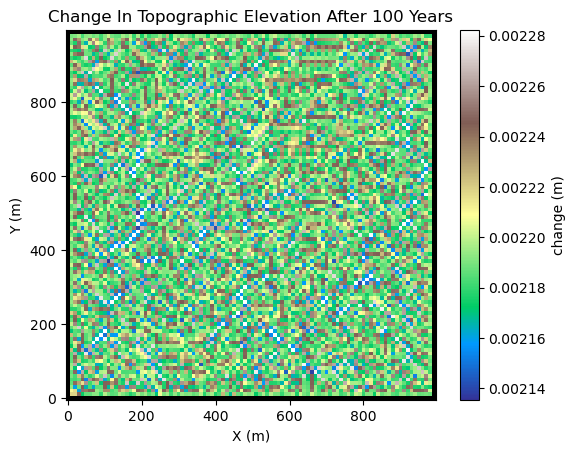

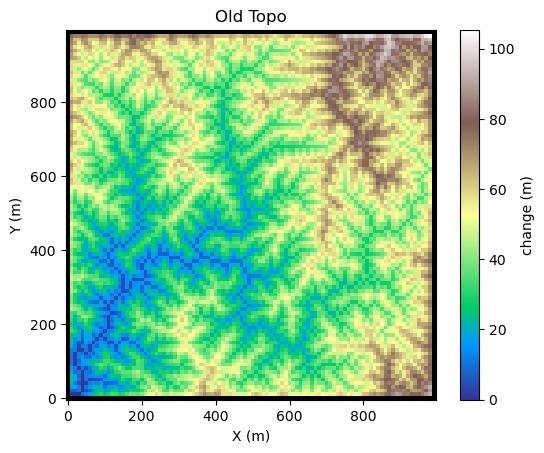

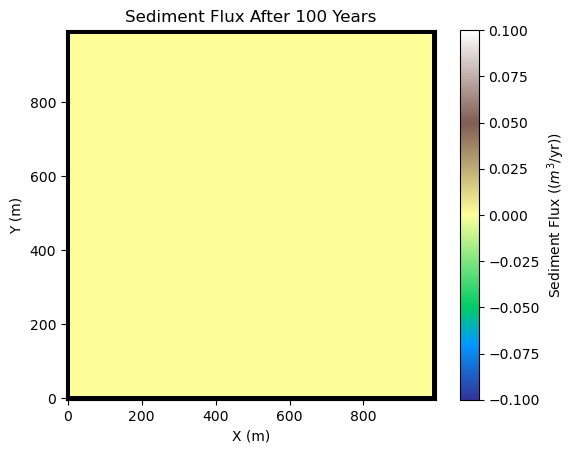

In [10]:
mg.at_node["change__topo"][:] = (mg.at_node["topographic__elevation"] - mg.at_node['old__topo'])
mg.at_node['change__topo'][outlet_id] = mg.at_node['change__topo'][outlet_id+1]
mg.at_node["topographic__elevation"] =mg.at_node['old__topo']+mg.at_node["change__topo"]

#mg.at_node['sediment__influx'][:] = mg.at_node['sediment__flux']
#mg.at_node['sediment__influx'][outlet_id] = mg.at_node['sediment__flux'][outlet_id+ncols+1]

# PLOT THE TOPOGRAPHY CHANGE & save
figelev = plt.figure()#Instantiate figure as empty plot
plot = plt.subplot()#Instantiate subplot as empty plot
imshow_grid(mg,'change__topo', plot_name='Change In Topographic Elevation After 100 Years', var_name = 'change', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)
fname = "final_plots/sample_drought_topoChange_"+ str(model_total_years) +"yrs.png"
figelev.savefig(fname, dpi='figure', format=None)    

# PLOT THE TOPOGRAPHY CHANGE & save
figelev = plt.figure()#Instantiate figure as empty plot
plot = plt.subplot()#Instantiate subplot as empty plot
imshow_grid(mg,'old__topo', plot_name='Old Topo', var_name = 'change', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)

    
# PLOT THE drainage area CHANGE & save
figelev = plt.figure()#Instantiate figure as empty plot
plot = plt.subplot()#Instantiate subplot as empty plot
imshow_grid(mg,'sediment__flux', plot_name='Sediment Flux After 100 Years', var_name = 'Sediment Flux', var_units=r'($m^3$/yr)', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)
fname = "final_plots/sample_drought_sedFlux_"+ str(model_total_years) +"yrs.png"
figelev.savefig(fname, dpi='figure', format=None)

NameError: name 'scalar' is not defined

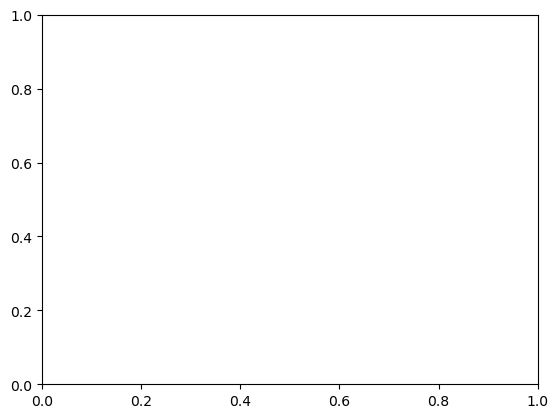

In [ ]:
# PLOT THE TOPOGRAPHY CHANGE & save
figelev = plt.figure()#Instantiate figure as empty plot
plot = plt.subplot()#Instantiate subplot as empty plot
imshow_grid(mg,'change__topo', plot_name='Change In Topographic Elevation After '+str(model_elapsed_years*scalar)+' Years', var_name = 'Elevation Change', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)
fname = "final_plots/sample_drought_topoChange_"+ str(model_total_years) +"yrs.png"
figelev.savefig(fname, dpi='figure', format=None)    

# PLOT THE drainage area CHANGE & save
figelev = plt.figure()#Instantiate figure as empty plot
plot = plt.subplot()#Instantiate subplot as empty plot
imshow_grid(mg,'sediment__flux', plot_name='Sediment Flux After 100 Years', var_name = 'Sediment Flux', var_units=r'$m^3$/yr', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)
fname = "final_plots/sample_drought_sedFlux_"+ str(model_total_years) +"yrs.png"
figelev.savefig(fname, dpi='figure', format=None)


In [ ]:
# PLOT THE TOPOGRAPHY 
figelev = plt.figure()#Instantiate figure as empty plot
plot = plt.subplot()#Instantiate subplot as empty plot
imshow_grid(mg, 'topographic__elevation', plot_name='Sample Topographic Elevation After 100 Years of Drought', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)
fname = "final_plots/sample_drought_FINAL_TOPO.png"
figelev.savefig(fname, dpi='figure', format=None)

In [ ]:
plt.figure(1)
imshow_grid(mg, z)  # plot the DEM
plt.plot(mg.node_x[outlet_node_to_sample], mg.node_y[outlet_node_to_sample], "yo")
plt.plot(mg.node_x[upstream_node_to_sample], mg.node_y[upstream_node_to_sample], "bo")
plt.plot(mg.node_x[midstream_node_to_sample], mg.node_y[midstream_node_to_sample], "go")

In [ ]:
avg_int_for_dis = int_pattern[0]#sum(int_pattern)/len(int_pattern)#sum(int_pattern)/len(int_pattern) mm/hr

## Calculate equilibrium discharge at each point for reference
outlet_eq_q = (avg_int_for_dis* mg.at_node["drainage_area"][outlet_node_to_sample])
midstream_eq_q = (avg_int_for_dis* mg.at_node["drainage_area"][midstream_node_to_sample])
upstream_eq_q = (avg_int_for_dis * mg.at_node["drainage_area"][upstream_node_to_sample])

plt.figure(1)

## PLOT EQUILIBRIUM DISCHARGE LINES
plt.axhline(y=outlet_eq_q, color='y', linestyle='--')
plt.axhline(y=midstream_eq_q, color='g', linestyle='--')
plt.axhline(y=upstream_eq_q, color='b', linestyle='--')

## NOW PLOT HYDROGRAPH LINES
plt.plot(hydrograph_time, discharge_at_outlet,"y-")
plt.plot(hydrograph_time, discharge_midstream,"g-")
plt.plot(hydrograph_time, discharge_upstream,"b-")

## Plot storm end and center of storm 
#plt.plot([spring_stm_avg_dur, spring_stm_avg_dur], [0, 100], "k-", linewidth=2, label="storm end")
#plt.plot([spring_stm_avg_dur / 2, spring_stm_avg_dur / 2], [0, 100], "k:", label="storm mid point")

plt.ylabel("Discharge (mm/hr)")
plt.xlabel("Time (hrs)")
plt.legend(loc="upper right")
plt.title("Hydrograph")
